In [124]:
import json
from typing import Dict, List, Tuple
from cognitivefactory.interactive_clustering.utils.preprocessing import preprocess
from cognitivefactory.interactive_clustering.utils.vectorization import vectorize
from scipy.sparse import csr_matrix

Load texts.

In [53]:
with open("../previous/dict_of_texts.json", "r") as dict_of_texts_file:
    dict_of_texts: Dict[str, str] = json.load(dict_of_texts_file)

In [57]:
dict_of_preprocessed_texts: Dict[str, str] = preprocess(
    dict_of_texts=dict_of_texts,
    spacy_language_model="fr_core_news_md",
)

In [125]:
dict_of_vectors: Dict[str, csr_matrix] = vectorize(
    dict_of_texts=dict_of_preprocessed_texts,
    vectorizer_type="tfidf",
)

Load true intents.

In [54]:
with open("../previous/dict_of_true_intents.json", "r") as dict_of_true_intents_file:
    dict_of_true_intents: Dict[str, str] = json.load(dict_of_true_intents_file)

Load constraints annotation evolution.

In [93]:
with open("../previous/constraints/bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c_-_0002.json", "r") as dict_of_constraints_annotation_file:
    dict_of_constraints_annotation: Dict[str, List[Tuple[str, str, str]]] = json.load(dict_of_constraints_annotation_file)

Load clustering evolution.

In [94]:
with open("../previous/clustering/bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c_-_0002.json", "r") as dict_of_clustering_file:
    dict_of_clustering: Dict[str, Dict[str, str]] = json.load(dict_of_clustering_file)

# 1. Consistency test

Define consistency test : train SVM + test on its trainset with high threshold score.

In [95]:
from typing import List
import numpy as np
# Definition du test
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
# Plot
from matplotlib import pyplot as plt
from matplotlib.figure import Figure

In [96]:
def consistency_test(x_train: List[str], y_train: List[str], prediction_score_threshold: float = 0.75, verbose: bool = False) -> float:
    """
    Test a TF-IDF + Linear SVM model on its own trainset with a high prediction score threshold in order to check data consistency.
    NB : if d1-score is low (i.e. less than 0.99), then trainset can be inconsistent.
    
    Args:
        x_train (List[str]): List of texts.
        y_train (List[str]): List of labels.
        prediction_score_threshold (float): Prediction score threshold to accept a prediction. Defaults to `0.75`.
        verbose(bool): Option to display information. Defaults to `False`.
    
    Returns:
        float: f1-score on trainset.
    """
    # Define a classifier (TF-IDF + Linear SVM).
    classifier = Pipeline(
        [
            ("tfidf", TfidfVectorizer(min_df=0, ngram_range=(1, 3), analyzer="word", sublinear_tf=True)),
            ("clf", CalibratedClassifierCV(LinearSVC())),
        ],
        verbose=False,
    )
    
    # Train model.
    classifier.fit(x_train, y_train)
    
    # Test model with a hight prediction score threshold.
    y_predict = []
    for x in x_train:
        # Get model inference with sorted prediction scores.
        prediction_scores = classifier.predict_proba([x])[0]
        sorted_indexes = np.argsort(prediction_scores)
        sorted_prediction_scores = prediction_scores[sorted_indexes][::-1]
        sorted_prediction_classes = classifier.classes_[sorted_indexes].tolist()[::-1]
        # Get first model prediction if and only if it is the only one with a prediction score higher than threshold.
        if (
            sorted_prediction_scores[0] >= prediction_score_threshold  # best classe with prediction score higher than threshold.
            and sorted_prediction_scores[1] < prediction_score_threshold  # AND other classes with prediction scores lower than threshold.
        ):
            y_predict.append(sorted_prediction_classes[0])
        else:
            y_predict.append("")
    if verbose:
        print("y_predict:", y_predict)
    
    # Compute and return f1-score.
    return f1_score(
        y_true=y_train,
        y_pred=y_predict,
        average="macro",
    )

Apply consistency test on each clustering iteration.

In [97]:
# Threshold
threshold: float = 0.70

# Consistency on groundtruth.
consistency_groundtruth: float = consistency_test(
    x_train=[dict_of_preprocessed_texts[text_id] for text_id in dict_of_preprocessed_texts.keys()],
    y_train=[dict_of_true_intents[text_id] for text_id in dict_of_preprocessed_texts.keys()],
    prediction_score_threshold=threshold,
)

# Consistency on clustering.
consistency_evolution: Dict[str, float] = {
    iteration: consistency_test(
        x_train=[dict_of_preprocessed_texts[text_id] for text_id in dict_of_preprocessed_texts.keys()],
        y_train=[str(clustering[text_id]) for text_id in dict_of_preprocessed_texts.keys()],
        prediction_score_threshold=threshold,
    )
    for iteration, clustering in dict_of_clustering.items()
}

c:\users\schildew\.envs\github-interactive-clustering-comparative-study\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\schildew\.envs\github-interactive-clustering-comparative-study\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\schildew\.envs\github-interactive-clustering-comparative-study\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\schildew\.envs\github-interactive-clustering-comparative-study\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\schildew\.envs\github-inter

Plot graph of consistency evolution.

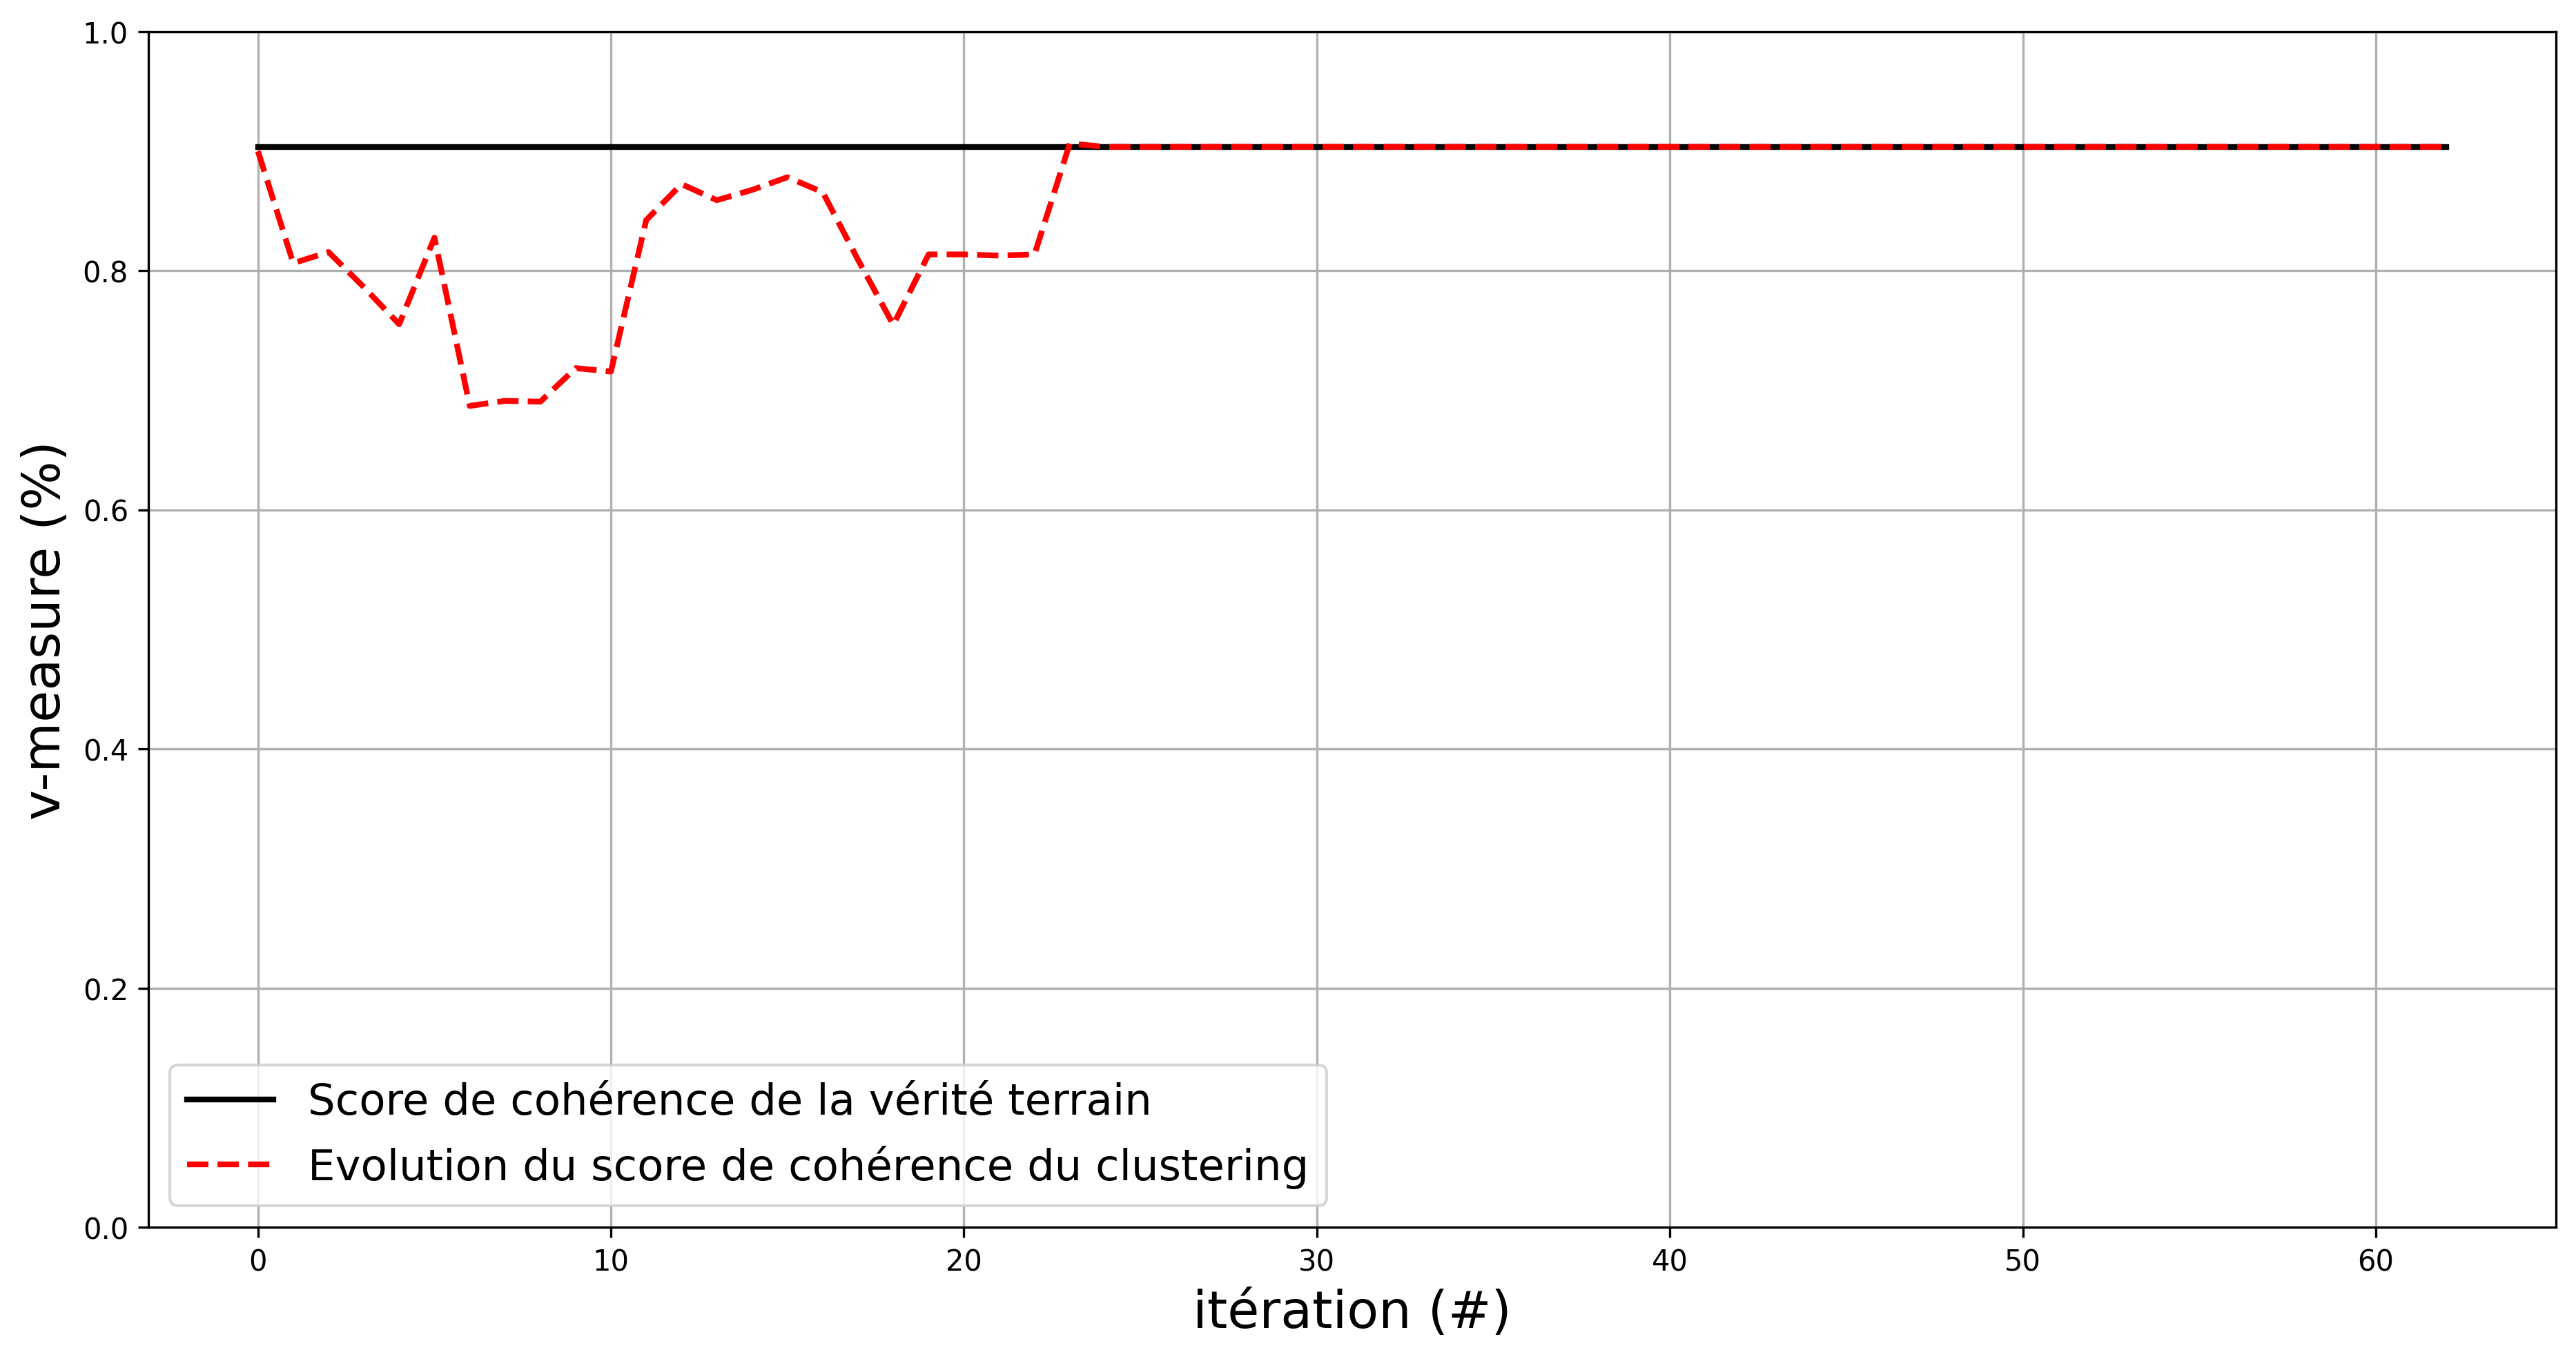

In [98]:
# Create a new figure.
fig_plot_consistency: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_consistency = fig_plot_consistency.gca()

# Set range of axis.
axis_plot_consistency.set_ylim(ymin=0, ymax=1)

# Plot consistency target on groundtruth.
axis_plot_consistency.plot(
    [int(iter_plot) for iter_plot in consistency_evolution.keys()],  # x
    [consistency_groundtruth for _ in consistency_evolution.values()],  # y
    label="Score de cohérence de la vérité terrain.",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)

# Plot consistency evolution on clustering.
axis_plot_consistency.plot(
    [int(iter_plot) for iter_plot in consistency_evolution.keys()],  # x
    [consistency_score for consistency_score in consistency_evolution.values()],  # y
    label="Evolution du score de cohérence du clustering.",
    marker="",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_consistency.set_xlabel("itération (#)", fontsize=18,)
axis_plot_consistency.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_consistency.legend(fontsize=15,)

# Plot the grid.
axis_plot_consistency.grid(True)

# 2. Agreement score

In [100]:
from typing import Dict, List, Optional, Tuple

Define agreement score between annotations and previous clustering.

In [103]:
def agreement_between_annotations_and_previous_clustering(annotations: List[Tuple[str, str, str]], clustering: Dict[str, str]) -> Optional[float]:
    """
    Count the proportion of annotations that is similar to previous clustering results ("MUST_LINK" when same cluster, "CANNOT_LINK" when different clusters).
    
    Args:
        annotations (List[Tuple[str, str, str]): The constraints annotations during an iteration.
        clustering (Dict[str, str]): The clustering result on the previous iteration.
        
    Returns:
        Optional[float]: The agreement between annotations and previous clustering. Can be `None` if there is no annotations.
    """
    ok: int = 0
    ko: int = 0
    skip: int = 0
    for annotation in annotations:
        # Get annotation and cluster result.
        cluster_data_1: int = clustering[annotation[0]]
        cluster_data_2: int = clustering[annotation[1]]
        constraint_type: str = annotation[2]
        # Case of agreement.
        if (
            (constraint_type == "MUST_LINK" and cluster_data_1 == cluster_data_2)
            or (constraint_type == "CANNOT_LINK" and cluster_data_1 != cluster_data_2)
        ):
            ok += 1
        # Case of disagreement.
        elif (
            (constraint_type == "MUST_LINK" and cluster_data_1 != cluster_data_2)
            or (constraint_type == "CANNOT_LINK" and cluster_data_1 == cluster_data_2)
        ):
            ko += 1
        # Case of not annotated.
        else:
            skip += 1
    # Return agreement score.
    return (
        ok / (ok + ko)
        if (ok + ko) != 0
        else None
    )

Compute agreement score on each clustering iteration. 

In [118]:
agreement_evolution: Dict[str, float] = {}

# Temp variables.
previous_iteration: Optional[str] = None
    
# Loop on iterations
for current_iteration in dict_of_constraints_annotation.keys():
    
    # Compute agreement.
    if previous_iteration is not None:
        agreement_evolution[current_iteration] = agreement_between_annotations_and_previous_clustering(
            annotations=dict_of_constraints_annotation[current_iteration],
            clustering=dict_of_clustering[previous_iteration]
        )
        
    # Update temporary variables.
    previous_iteration = current_iteration

Plot graph of agreement evolution.

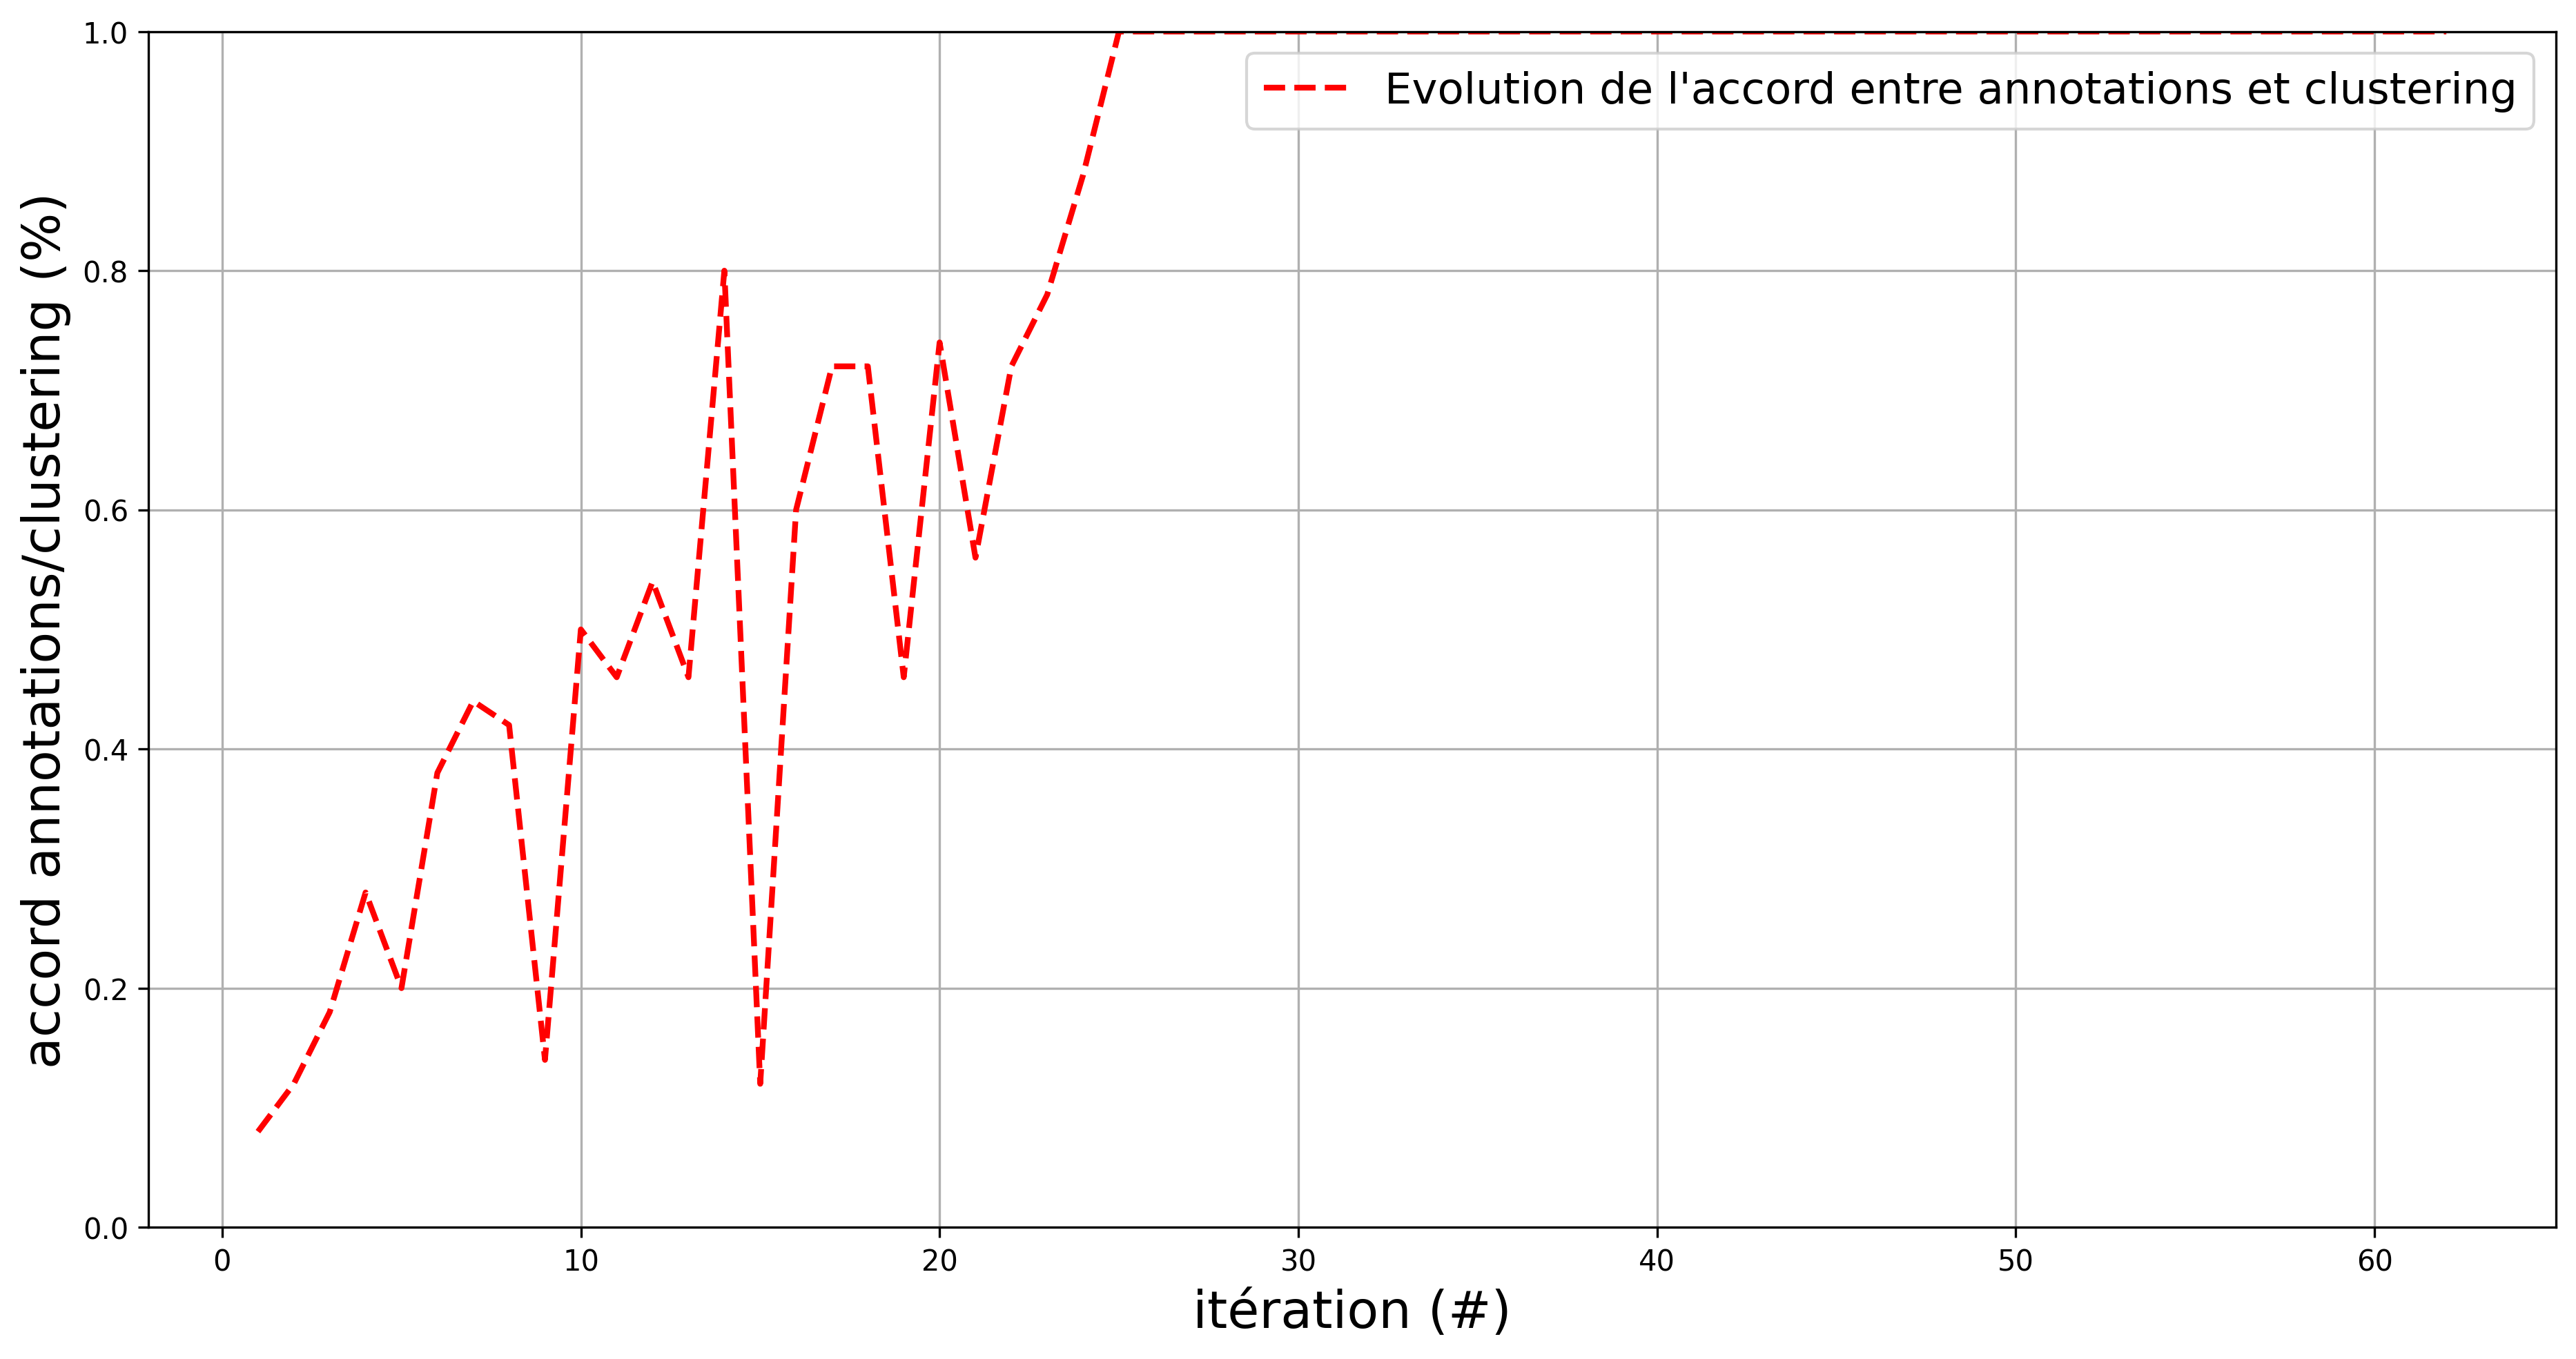

In [119]:
# Create a new figure.
fig_plot_agreement: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_agreement = fig_plot_agreement.gca()

# Set range of axis.
axis_plot_agreement.set_ylim(ymin=0, ymax=1)

# Plot agreement evolution.
axis_plot_agreement.plot(
    [int(iter_plot) for iter_plot in agreement_evolution.keys()],  # x
    [agreement_score for agreement_score in agreement_evolution.values()],  # y
    label="Evolution de l'accord entre annotations et clustering.",
    marker="",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_agreement.set_xlabel("itération (#)", fontsize=18,)
axis_plot_agreement.set_ylabel("accord annotations/clustering (%)", fontsize=18,)

# Plot the legend.
axis_plot_agreement.legend(fontsize=15,)

# Plot the grid.
axis_plot_agreement.grid(True)

# 3. VMeasure stabilization 

In [120]:
from typing import Dict, Optional
from sklearn import metrics

Compute vmeasure stabilization on each clustering iteration. 

In [142]:
vmeasure_stabilization_0: Dict[str, float] = {}
vmeasure_stabilization_1: Dict[str, float] = {}
vmeasure_stabilization_2: Dict[str, float] = {}
vmeasure_stabilization_3: Dict[str, float] = {}

# Temp variables.
previous_iteration: Optional[str] = None
preprevious_iteration: Optional[str] = None
prepreprevious_iteration: Optional[str] = None
    
# Loop on iterations.
for current_iteration in dict_of_clustering.keys():
    
    # Difference to groundtruth.
    vmeasure_stabilization_0[current_iteration] = metrics.v_measure_score(
        labels_true=[str(dict_of_true_intents[text_id]) for text_id in dict_of_true_intents.keys()],
        labels_pred=[str(dict_of_clustering[current_iteration][text_id]) for text_id in dict_of_true_intents.keys()],
    )
    # Difference between 2 iterations.
    if previous_iteration is not None:
        vmeasure_stabilization_1[current_iteration] = metrics.v_measure_score(
            labels_true=[str(dict_of_clustering[previous_iteration][text_id]) for text_id in dict_of_clustering[previous_iteration].keys()],
            labels_pred=[str(dict_of_clustering[current_iteration][text_id]) for text_id in dict_of_clustering[previous_iteration].keys()],
        )
    # Difference between 3 iterations.
    if preprevious_iteration is not None:
        vmeasure_stabilization_2[current_iteration] = metrics.v_measure_score(
            labels_true=[str(dict_of_clustering[preprevious_iteration][text_id]) for text_id in dict_of_clustering[preprevious_iteration].keys()],
            labels_pred=[str(dict_of_clustering[current_iteration][text_id]) for text_id in dict_of_clustering[previous_iteration].keys()],
        )
    # Difference between 4 iterations.
    if prepreprevious_iteration is not None:
        vmeasure_stabilization_3[current_iteration] = metrics.v_measure_score(
            labels_true=[str(dict_of_clustering[prepreprevious_iteration][text_id]) for text_id in dict_of_clustering[prepreprevious_iteration].keys()],
            labels_pred=[str(dict_of_clustering[current_iteration][text_id]) for text_id in dict_of_clustering[previous_iteration].keys()],
        )
    # Update temporary variables.
    prepreprevious_iteration = preprevious_iteration
    preprevious_iteration = previous_iteration
    previous_iteration = current_iteration

Plot graph of vmeasure stabilization evolution.

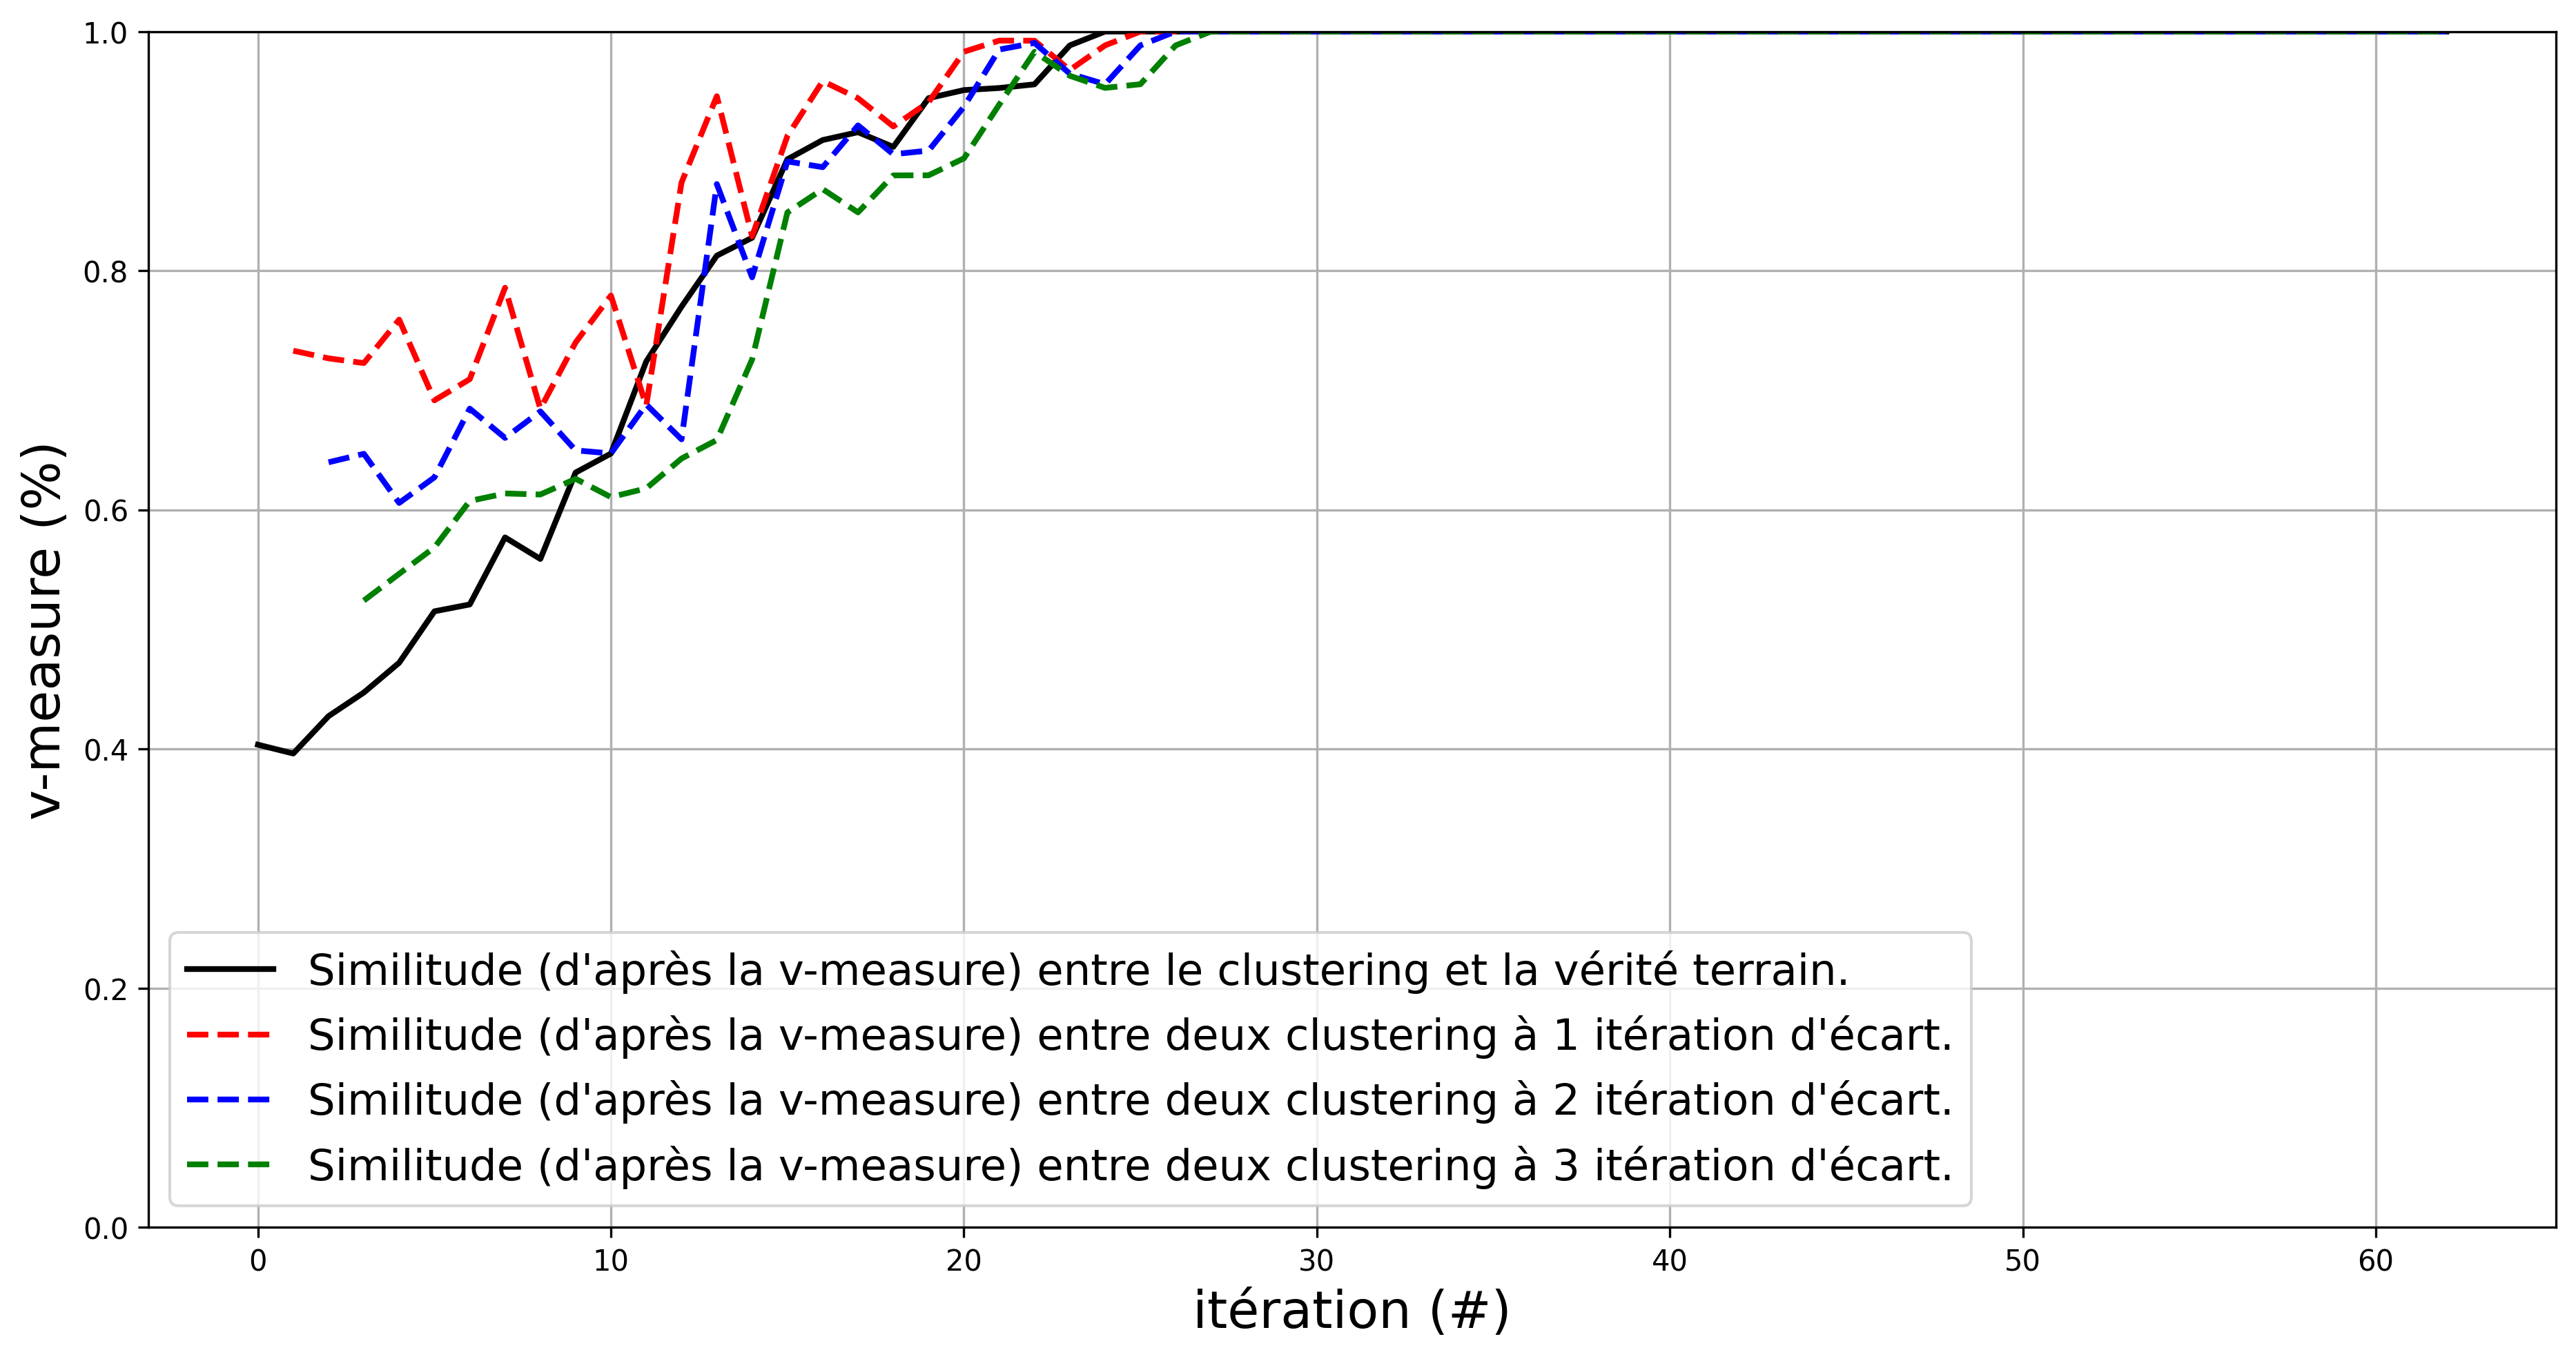

In [144]:
# Create a new figure.
fig_plot_vmeasure_stabilization: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_vmeasure_stabilization = fig_plot_vmeasure_stabilization.gca()

# Set range of axis.
axis_plot_vmeasure_stabilization.set_ylim(ymin=0, ymax=1)

# Plot vmeasure comparison to groundtruth.
axis_plot_vmeasure_stabilization.plot(
    [int(iter_plot) for iter_plot in vmeasure_stabilization_0.keys()],  # x
    [vmeasure_score for vmeasure_score in vmeasure_stabilization_0.values()],  # y
    label="Similitude (d'après la v-measure) entre le clustering et la vérité terrain.",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)

# Plot vmeasure stabilization evolution at 1 iteration.
axis_plot_vmeasure_stabilization.plot(
    [int(iter_plot) for iter_plot in vmeasure_stabilization_1.keys()],  # x
    [vmeasure_score for vmeasure_score in vmeasure_stabilization_1.values()],  # y
    label="Similitude (d'après la v-measure) entre deux clustering à 1 itération d'écart.",
    marker="",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Plot vmeasure stabilization evolution at 2 iteration.
axis_plot_vmeasure_stabilization.plot(
    [int(iter_plot) for iter_plot in vmeasure_stabilization_2.keys()],  # x
    [vmeasure_score for vmeasure_score in vmeasure_stabilization_2.values()],  # y
    label="Similitude (d'après la v-measure) entre deux clustering à 2 itération d'écart.",
    marker="",
    markerfacecolor="blue",
    markersize=5,
    color="blue",
    linewidth=2,
    linestyle="--",
)

# Plot vmeasure stabilization evolution at 3 iteration.
axis_plot_vmeasure_stabilization.plot(
    [int(iter_plot) for iter_plot in vmeasure_stabilization_3.keys()],  # x
    [vmeasure_score for vmeasure_score in vmeasure_stabilization_3.values()],  # y
    label="Similitude (d'après la v-measure) entre deux clustering à 3 itération d'écart.",
    marker="",
    markerfacecolor="green",
    markersize=5,
    color="green",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_vmeasure_stabilization.set_xlabel("itération (#)", fontsize=18,)
axis_plot_vmeasure_stabilization.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_vmeasure_stabilization.legend(fontsize=15,)

# Plot the grid.
axis_plot_vmeasure_stabilization.grid(True)

# 4. FMC stabilization

In [127]:
from typing import List, Dict
from cognitivefactory.features_maximization_metric.fmc import FeaturesMaximizationMetric
from scipy.sparse import csr_matrix, vstack
from sklearn.feature_extraction.text import TfidfVectorizer

Compute FMC stabilization on each clustering iteration. 

In [140]:
fmc_stabilization_0: Dict[str, float] = {}
fmc_stabilization_1: Dict[str, float] = {}
fmc_stabilization_2: Dict[str, float] = {}
fmc_stabilization_3: Dict[str, float] = {}
    
# Define vectorizer.
vectorizer = TfidfVectorizer(min_df=0, ngram_range=(1, 3), analyzer="word", sublinear_tf=True)
matrix_of_vectors: csr_matrix = vectorizer.fit_transform(
    [
        str(dict_of_preprocessed_texts[text_ID])
        for text_ID in dict_of_preprocessed_texts.keys()
    ]
)
list_of_possible_vectors_features: List[str] = list(vectorizer.get_feature_names_out())
    
# groundtruth FMC modelization.
grountruth_fmc_modelization: FeaturesMaximizationMetric = FeaturesMaximizationMetric(
    data_vectors=matrix_of_vectors,
    data_classes=[dict_of_true_intents[text_ID] for text_ID in dict_of_preprocessed_texts.keys()],
    list_of_possible_features=list_of_possible_vectors_features,
    amplification_factor=1,
)

# Temp variables.
previous_iteration: Optional[str] = None
previous_fmc_modelization: Optional[FeaturesMaximizationMetric] = None
preprevious_iteration: Optional[str] = None
preprevious_fmc_modelization: Optional[FeaturesMaximizationMetric] = None
prepreprevious_iteration: Optional[str] = None
prepreprevious_fmc_modelization: Optional[FeaturesMaximizationMetric] = None
    
# Loop on iterations.
for current_iteration in dict_of_clustering.keys():
    
    # Current FMC modelization.
    current_fmc_modelization: FeaturesMaximizationMetric = FeaturesMaximizationMetric(
        data_vectors=matrix_of_vectors,
        data_classes=[dict_of_clustering[current_iteration][text_ID] for text_ID in dict_of_preprocessed_texts.keys()],
        list_of_possible_features=list_of_possible_vectors_features,
        amplification_factor=1,
    )
    
    # Difference to groundtruth.
    fmc_stabilization_0[current_iteration] = current_fmc_modelization.compare(
        fmc_reference=grountruth_fmc_modelization,
        rounded=5,
    )[2]

    # Difference between 2 iterations.
    if previous_iteration is not None:
        fmc_stabilization_1[current_iteration] = current_fmc_modelization.compare(
            fmc_reference=previous_fmc_modelization,
            rounded=5,
        )[2]
    # Difference between 3 iterations.
    if preprevious_iteration is not None:
        fmc_stabilization_2[current_iteration] = current_fmc_modelization.compare(
            fmc_reference=preprevious_fmc_modelization,
            rounded=5,
        )[2]
    # Difference between 4 iterations.
    if prepreprevious_iteration is not None:
        fmc_stabilization_3[current_iteration] = current_fmc_modelization.compare(
            fmc_reference=prepreprevious_fmc_modelization,
            rounded=5,
        )[2]
    # Update temporary variables.
    prepreprevious_iteration = preprevious_iteration
    prepreprevious_fmc_modelization = preprevious_fmc_modelization
    preprevious_iteration = previous_iteration
    preprevious_fmc_modelization = previous_fmc_modelization
    previous_iteration = current_iteration
    previous_fmc_modelization = current_fmc_modelization

Plot graph of FMC stabilization evolution.

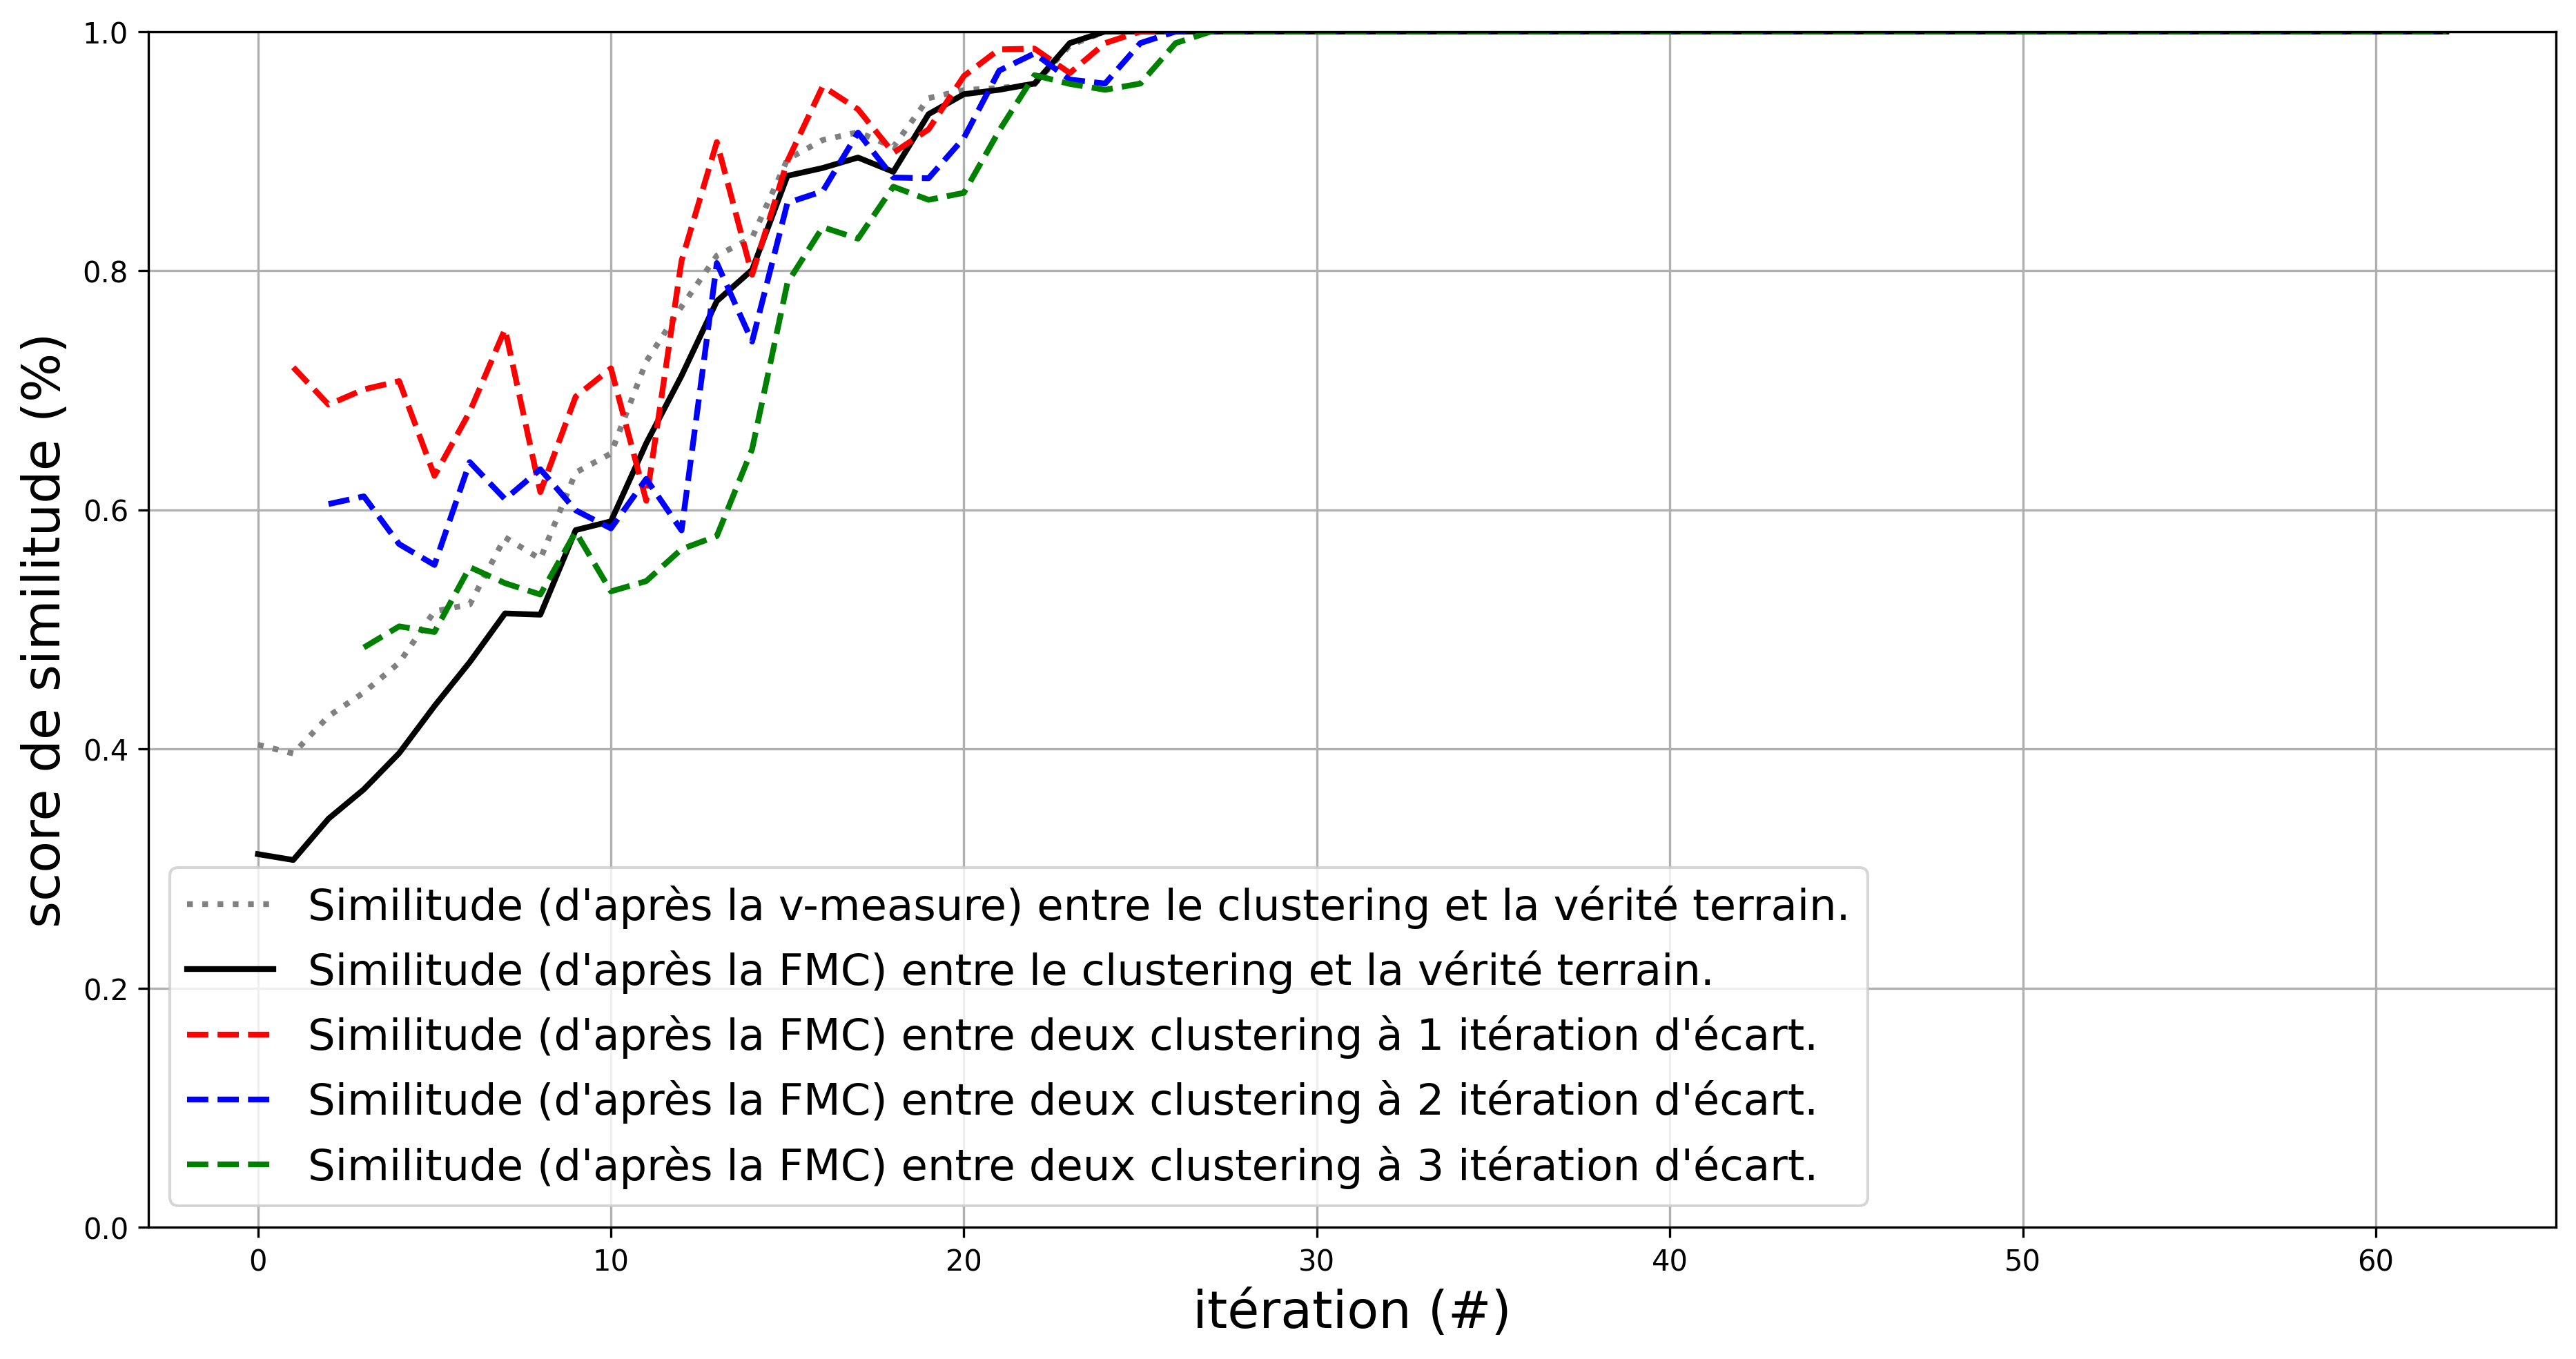

In [148]:
# Create a new figure.
fig_plot_fmc_stabilization: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_fmc_stabilization = fig_plot_fmc_stabilization.gca()

# Set range of axis.
axis_plot_fmc_stabilization.set_ylim(ymin=0, ymax=1)

# Plot vmeasure comparison to groundtruth.
axis_plot_fmc_stabilization.plot(
    [int(iter_plot) for iter_plot in vmeasure_stabilization_0.keys()],  # x
    [vmeasure_score for vmeasure_score in vmeasure_stabilization_0.values()],  # y
    label="Similitude (d'après la v-measure) entre le clustering et la vérité terrain.",
    marker="",
    markerfacecolor="gray",
    markersize=5,
    color="gray",
    linewidth=2,
    linestyle=":",
)

# Plot fmc comparison to groundtruth.
axis_plot_fmc_stabilization.plot(
    [int(iter_plot) for iter_plot in fmc_stabilization_0.keys()],  # x
    [fmc_score for fmc_score in fmc_stabilization_0.values()],  # y
    label="Similitude (d'après la FMC) entre le clustering et la vérité terrain.",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle="-",
)

# Plot fmc stabilization evolution at 1 iteration.
axis_plot_fmc_stabilization.plot(
    [int(iter_plot) for iter_plot in fmc_stabilization_1.keys()],  # x
    [fmc_score for fmc_score in fmc_stabilization_1.values()],  # y
    label="Similitude (d'après la FMC) entre deux clustering à 1 itération d'écart.",
    marker="",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Plot vmeasure stabilization evolution at 2 iteration.
axis_plot_fmc_stabilization.plot(
    [int(iter_plot) for iter_plot in fmc_stabilization_2.keys()],  # x
    [fmc_score for fmc_score in fmc_stabilization_2.values()],  # y
    label="Similitude (d'après la FMC) entre deux clustering à 2 itération d'écart.",
    marker="",
    markerfacecolor="blue",
    markersize=5,
    color="blue",
    linewidth=2,
    linestyle="--",
)

# Plot vmeasure stabilization evolution at 3 iteration.
axis_plot_fmc_stabilization.plot(
    [int(iter_plot) for iter_plot in fmc_stabilization_3.keys()],  # x
    [fmc_score for fmc_score in fmc_stabilization_3.values()],  # y
    label="Similitude (d'après la FMC) entre deux clustering à 3 itération d'écart.",
    marker="",
    markerfacecolor="green",
    markersize=5,
    color="green",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_fmc_stabilization.set_xlabel("itération (#)", fontsize=18,)
axis_plot_fmc_stabilization.set_ylabel("score de similitude (%)", fontsize=18,)

# Plot the legend.
axis_plot_fmc_stabilization.legend(fontsize=15,)

# Plot the grid.
axis_plot_fmc_stabilization.grid(True)

# 5. FMC summary